## **Enhancing LLM inferencing with RAG and fine-tuned LLMs**
### **Generative AI Workshop, AI-ML Systems Conference - 2023, Bengaluru**
---
Anupam Purwar & Abhinav Kimothi

Agenda -

1. Inference OpenAI and Open Source LLMs
2. Discuss the challenges with LLMs
3. Demonstrate Retrieval Augmented Generation (RAG)
4. Fine tune OpenAI models
5. Fully fine-tune an open source LLM

#### just some notebook formatting

In [ ]:
### Run Only when using colab for formatting table display
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
### Run Only when using colab for formatting table display
%load_ext google.colab.data_table

# Installing Dependencies

#### Importing Libraries

**openai** - To inference OpenAI's GPT series of models and fine-tune them.

**text_generation** - To inference an open source model on Hugging Face (Falcon 7B Instruct)

**gradio** - To build an interface.

**pypdf2** - To read PDF documents for RAG.

**tiktoken** - To count the number of tokens in a prompt.

**requests** - For making API requests

**Beautiful Soup** - To extract a webpage for RAG

**transformers** - To access models from HuggingFace

**datasets** - To access HuggingFace Datasets

**langchain** - Framework to use for RAG

**faiss-cpu** - To save and search embeddings for RAG



In [ ]:
import os
print(os.getcwd())

In [ ]:
%pip install -r ../requirements.txt

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import openai
import pandas as pd
import gradio as gr
import requests, json
from text_generation import Client
from bs4 import BeautifulSoup
import PyPDF2
import io
import tiktoken
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
import random
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from datasets import Dataset
import transformers
import torch
from configparser import ConfigParser

from accelerate import Accelerator


#### **OpenAI API Key**



OpenAI models are proprietary. In order to access them, you have to create an account and get an api key. You can get an api key [here](https://platform.openai.com/account/api-keys)

In [3]:
config_object = ConfigParser()
config_object.read("../config.ini")

openai.api_key = config_object["OPENAI"]["openai_key"]

#### **HuggingFace token**

HuggingFace has fast become the choice of platform for Open Source LLMs. We will use HuggingFace to inference and finetune opensource models. You can get your access token [here](https://huggingface.co/settings/tokens)

In [4]:
hf_token=config_object["HuggingFace"]["hf_token"]

# Inference Available LLMs

#### OpenAI models

1. Text Completion Models
- text-davinci-003 [Context Window of 4,097 tokens] (will be deprecated in Jan 2024)
2. Chat Models
- gpt-3.5-turbo [Context Window of 4,097 tokens]
- gpt-3.5-turbo-16k [Context Window of 16,385 tokens]
- gpt-4 [Context Window of 8,192 tokens]
- gpt-4-32k [Context Window of 32,768 tokens]

In [5]:
prompt="Write an introduction to the workshop on Enhancing LLM inferencing with RAG and fine-tuned LLMs."

##### Completion model

In [6]:
response=openai.Completion.create(model="text-davinci-003",
                                        prompt=prompt,
                                        temperature=.7,
                                        max_tokens=500,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="tutuser001")

**Optional Reading** : Read [this blog](https://medium.com/mlearning-ai/7-key-prompt-engineering-parameters-everyone-should-know-4b3a330865a8) to find out more about the openai API parameters

In [7]:
print(response)

{
  "warning": "This model version is deprecated. Migrate before January 4, 2024 to avoid disruption of service. Learn more https://platform.openai.com/docs/deprecations",
  "id": "cmpl-8EU98xXAAse2yOFwBizV9m6L4d6YS",
  "object": "text_completion",
  "created": 1698463166,
  "model": "text-davinci-003",
  "choices": [
    {
      "text": "\n\nWelcome to the workshop on Enhancing LLM Inferencing with RAG and Fine-Tuned LLMs! This workshop will provide an introduction to RAG (Recurrent Attention Graphs) and how it can be used to improve the performance of Long Short-Term Memory (LSTM) models. We will also discuss how fine-tuning these LSTMs can help increase accuracy and reduce inference time. Finally, we\u2019ll take a look at some real-world applications for using these techniques in natural language processing tasks. By the end of this workshop, you should have a better understanding of how RAG and fine-tuned LSTMs can be used to enhance inferencing for your own projects.",
      "ind

**Optional** : Why monitoring tokens is important? Take a look at the [pricing of different OpenAI models](https://openai.com/pricing).

In [ ]:
print(response.choices[0]["text"])

##### Chat Model

In [ ]:
response=openai.ChatCompletion.create(model="gpt-3.5-turbo",
                            messages=[{"role":"user","content":prompt}],
                            temperature=.7,
                            max_tokens=500,
                            top_p=1,
                            frequency_penalty=1,
                            presence_penalty=1,
                            user="tutuser001")

In [ ]:
print(response)

In [ ]:
print(response.choices[0]["message"]["content"])

In [ ]:
print(openai.ChatCompletion.create(model="gpt-4",
                            messages=[{"role":"user","content":prompt}],
                            temperature=.7,
                            max_tokens=500,
                            top_p=1,
                            frequency_penalty=1,
                            presence_penalty=1,
                            user="tutuser001").choices[0]["message"]["content"])

#### OpenSource LLMs (Using HuggingFace)

##### Falcon 7B using Inference API



In [ ]:
client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
response=client.generate(prompt=prompt,
                         max_new_tokens=256,
                         do_sample=True,
                         top_k=10)

In [ ]:
print(response)

In [ ]:
print(response.generated_text)

##### Zephyr 7B Alpha by HuggingFace (fine-tuned version of mistralai's Mistral-7B-v0.1)


In [ ]:
client = Client("https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-alpha",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
response=client.generate(prompt=prompt,
                         max_new_tokens=256,
                         do_sample=True,
                         top_k=10)

In [ ]:
print(response)

##### Run locally : **EleutherAI's pythia-70m**
Downloading a 'smallish' 70 million parameter model using Hugging Face Pipeline

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="EleutherAI/pythia-70m")

In [ ]:
response = pipe(prompt, max_length=50, do_sample=True, temperature=0.7)


In [ ]:
response[0]['generated_text']

#### Optional (Building a gradio interface)

In [ ]:
def generate(prompt, max_tokens, model="gpt-3.5-turbo"):

    if model=='text-davinci-003':
      response=openai.Completion.create(model=model,
                                        prompt=prompt,
                                        temperature=.7,
                                        max_tokens=max_tokens,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="user_id")
      output = response.choices[0].text
      tokens=response['usage']['total_tokens']

    elif model=='Falcon 7B':
      client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
      response=client.generate(prompt=prompt,
                               max_new_tokens=max_tokens)
      
      output=response.generated_text
      tokens=response.details.generated_tokens

    elif model=='Zephyr 7B Alpha':
      client = Client("https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-alpha",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
      response=client.generate(prompt=prompt,
                               max_new_tokens=max_tokens)
      
      output=response.generated_text
      tokens=response.details.generated_tokens

    else:
      response = openai.ChatCompletion.create(model=model,
                                              messages=[{"role":"user","content":prompt}],
                                              temperature=.7,
                                              max_tokens=max_tokens,
                                              top_p=1,
                                              frequency_penalty=1,
                                              presence_penalty=1,
                                              user="user_id")
      output = response.choices[0].message["content"]
      tokens=response['usage']['total_tokens']

    return output, tokens

demo = gr.Interface(fn=generate,
                    inputs=[gr.Textbox(label="Prompt"),
                            gr.Slider(label="Max new tokens", value=200,  maximum=1024, minimum=1),
                            gr.Dropdown(["gpt-3.5-turbo", "gpt-4", "text-davinci-003","Falcon 7B","Zephyr 7B Alpha"],label="Model",value="gpt-3.5-turbo")],
                    outputs=[gr.Textbox(label="Completion"),gr.Textbox(label="Tokens")])

gr.close_all()

demo.launch(share=True,server_port=7000)

# Problems with LLMs

Let's ask a question about this conference

In [ ]:
prompt="Where is the 3rd AIML systems conference happening?"

In [ ]:
print(openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":prompt}],
                             max_tokens=100,temperature=0.9).choices[0].message["content"])

In [ ]:
print(openai.Completion.create(model='text-davinci-003',
                                        prompt=prompt,
                                        temperature=.7,
                                        max_tokens=100,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="user_id").choices[0].text)

In [ ]:
client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
print(client.generate(prompt=prompt,
                               max_new_tokens=100).generated_text)

In [ ]:
client = Client("https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-alpha",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
print(client.generate(prompt=prompt,
                               max_new_tokens=100).generated_text)

- Hallucinations - Very confidently, provide incorrect information.
- Missing Knowledge - Not having information (information available only that is available the training data)

# Retrieval Augmented Generation (RAG)

##### Concept

1. Retrieve - Fetch information from a source that is external to the model
2. Augment - Add the context of the retrieved information to the prompt
3. Generation - Inference the LLM with the added context to generate completions

![](https://miro.medium.com/v2/resize:fit:875/1*LNVVvuZPLgdOWakC0hQcig.png)


[Source](https://towardsai.net/p/machine-learning/information-retrieval-for-retrieval-augmented-generation)

##### Step 1: Retrieval

We have the information in the AIML System's Website (https://www.aimlsystems.org/2023/)

Can we fetch this information and provide it to the LLM?

In [ ]:
def extract_page(link): #### Function to extract text from weblink ####
    address=link #### Store weblink in address variable ####
    response=requests.get(address) #### Get response from weblink using requests ####
    soup = BeautifulSoup(response.content, 'html.parser') #### Parse response using BeautifulSoup ####
    text=soup.get_text() #### Extract text from parsed response ####
    lines = filter(lambda x: x.strip(), text.splitlines()) #### Filter out empty lines ####
    website_text = "\n".join(lines) #### Join lines to form text ####
    return website_text

In [ ]:
website_text=extract_page("https://www.aimlsystems.org/2023/")

In [ ]:
print(website_text)

##### Step 2 : Augmentation

We will augment this retrieved information to our original prompt

In [ ]:
prompt="When and where is the 3rd AIML Systems conference happening?"

In [ ]:
augmented_prompt=f"You have been provided a context in [[[]]] and a prompt below. Respond to the prompt only from the context. If the information is not present in the context, respond with \"I don't know\"\nContext : [[[{website_text}]]]\nPrompt : {prompt}"

In [ ]:
print(augmented_prompt)

##### Step 3 : Generation

In [ ]:
print(openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":augmented_prompt}],
                             max_tokens=100,temperature=0.9).choices[0].message["content"])

In [ ]:
client = Client("https://api-inference.huggingface.co/models/tiiuae/falcon-7b-instruct",
                      headers={"Authorization": f"Bearer {hf_token}"},
                      timeout=120)
print(client.generate(prompt=augmented_prompt,
                               max_new_tokens=100, temperature=0.8).generated_text)

##### A cautionary note on context windows

In [ ]:
encoding_name="cl100k_base"
encoding = tiktoken.get_encoding(encoding_name)
len(encoding.encode(website_text))

In [ ]:
url = 'http://lib.ysu.am/open_books/413214.pdf'
response = requests.get(url)
f = io.BytesIO(response.content)
reader = PyPDF2.PdfReader(f)
pages = reader.pages
# get all pages data
text = "".join([page.extract_text() for page in pages])

In [ ]:
len(encoding.encode(text))

# RAG at Scale

- We split the data (chunking)
- We convert the data into embeddings
- We store the data in a Vector Database

Instead of retrieving directly from the source, we retrieve information from the vector database by searching through chunks that are semantically similar to the prompt

![](https://media.licdn.com/dms/image/D5612AQFF3SyoukN5aQ/article-inline_image-shrink_400_744/0/1688793041451?e=1701907200&v=beta&t=4XgPjzI2I18EktDv8RWLeYawNShe_EXacuEIIRda1WM)

[Source](https://www.linkedin.com/pulse/question-answer-bot-using-openai-langchain-faiss-satish-srinivasan/)

In [ ]:
def split_text_and_create_embeddings(text): #### Function to create embeddings from text ####
    with open('../Data/temp.txt','w') as f: #### Write text to a temporary file ####
         f.write(text) #### Write text to a temporary file ####
         f.close() #### Close temporary file ####
    loader=TextLoader('../Data/temp.txt') #### Load temporary file using TextLoader ####
    document=loader.load() #### Extract text from temporary file ####
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=2000) #### Initialize text splitter to split text into chunks of 10000 tokens ####
    docs = text_splitter.split_documents(document) #### Split document into chunks of 10000 tokens ####
    num_emb=len(docs) #### Count number of embeddings ####
    embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key) #### Initialize embeddings ####
    db = FAISS.from_documents(docs, embeddings) #### Create embeddings from text ####
    return db, num_emb #### Return database with embeddings and number of embeddings ####

In [ ]:
vector_db, num_emb=split_text_and_create_embeddings(text)

In [ ]:
print(num_emb)

In [ ]:
vector_db.save_local(folder_path="../Data/")

In [ ]:
embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key)

In [ ]:
local_vectors=FAISS.load_local(folder_path="../Data/",embeddings=embeddings)

In [ ]:
def search_context(db,query): ###### search_context function
     defin=db.similarity_search(query) ###### call the FAISS similarity_search function that searches the database for the most relevant section to the user question and orders the results in descending order of relevance
     return defin[0].page_content ###### return the most relevant section to the user question

In [ ]:
prompt="Why do great firms fail?"

In [ ]:
context=search_context(local_vectors,prompt)

In [ ]:
print(context)

In [ ]:
augmented_prompt=f"You have been provided a context in [[[]]] and a prompt below. Respond to the prompt only from the context. If the information is not present in the context, respond with \"I don't know\"\nContext : [[[{context}]]]\nPrompt : {prompt}"

In [ ]:
print(augmented_prompt)

In [ ]:
openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":augmented_prompt}],
                             max_tokens=250,temperature=0.7).choices[0].message["content"]

In [ ]:
openai.ChatCompletion.create(model="gpt-3.5-turbo",
                             messages=[{"role":"user","content":prompt}],
                             max_tokens=250,temperature=0.7).choices[0].message["content"]

# Why Fine-tune?

Taking a general purpose model and train it to perform a specialized/specific task

- Hallucinations
- RAG Misses
- Learn New Information (When data size is large)
- Cost Optimization
- Privacy

**Challenges**

- Need quality data
- Upfront cost
- Expertise

##### What will we do?

- Fine tuning OpenAI models
- Fine tuning a smallish model (On CPU)
- Fine tuning large model like Llama2 (QLora On GPUs - Only code, no code-along)

##### Overview

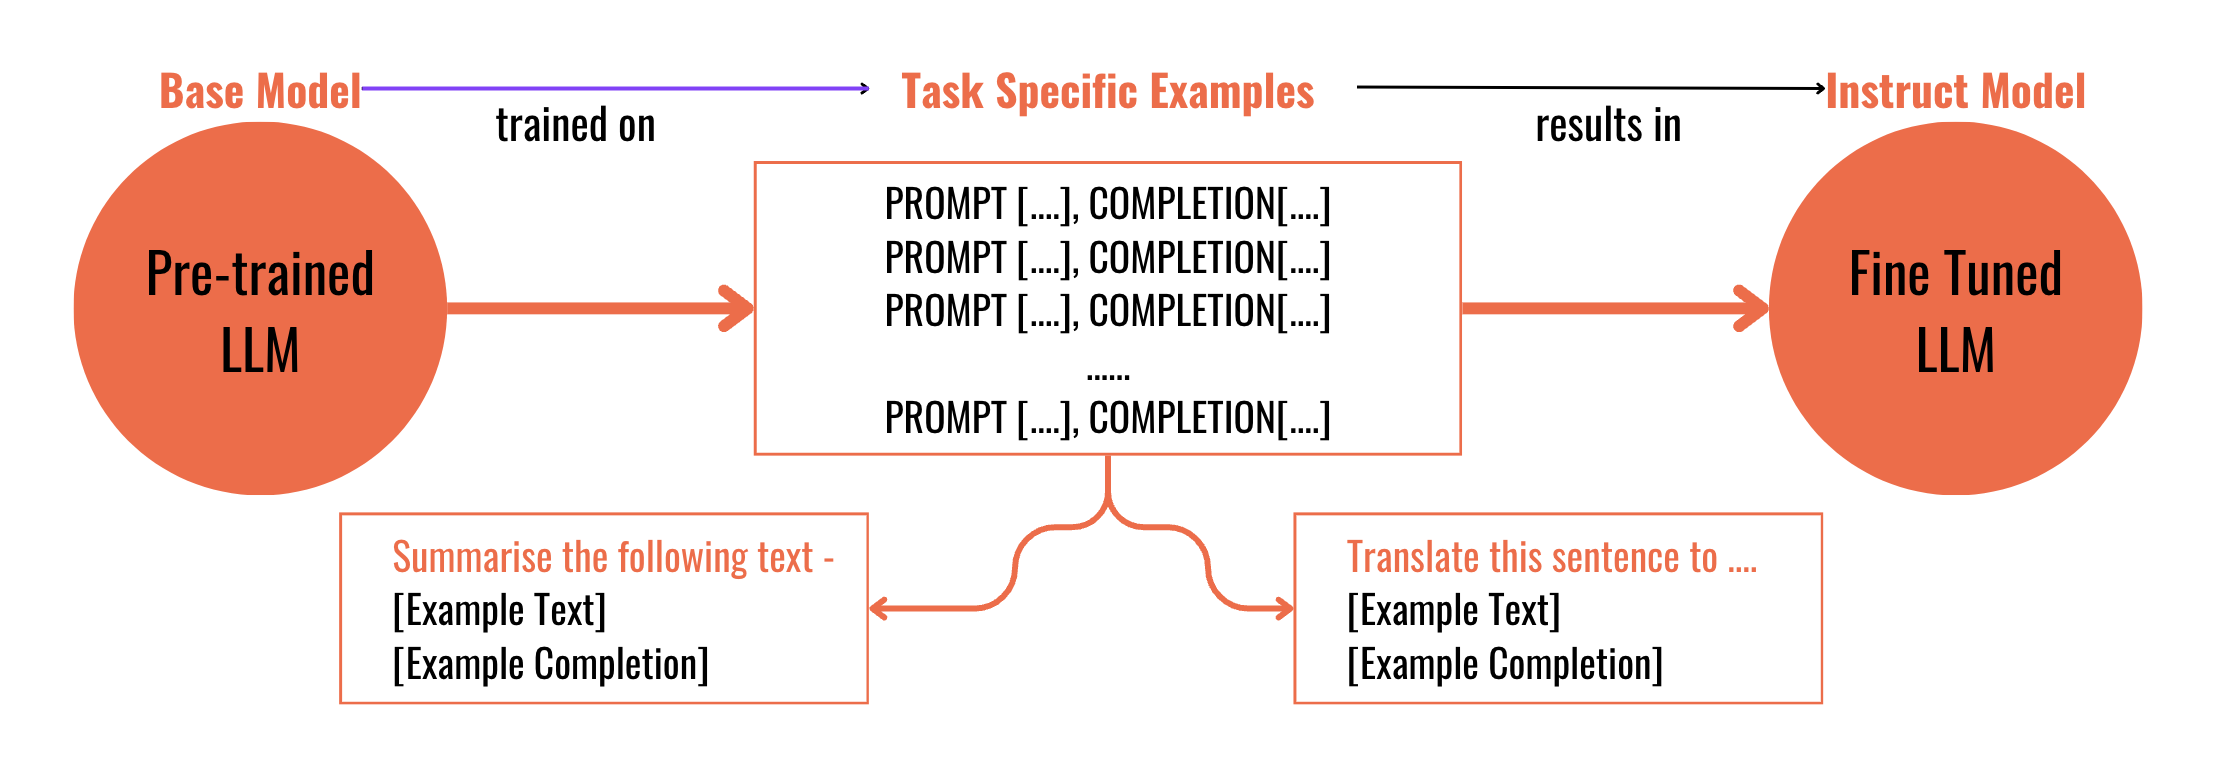

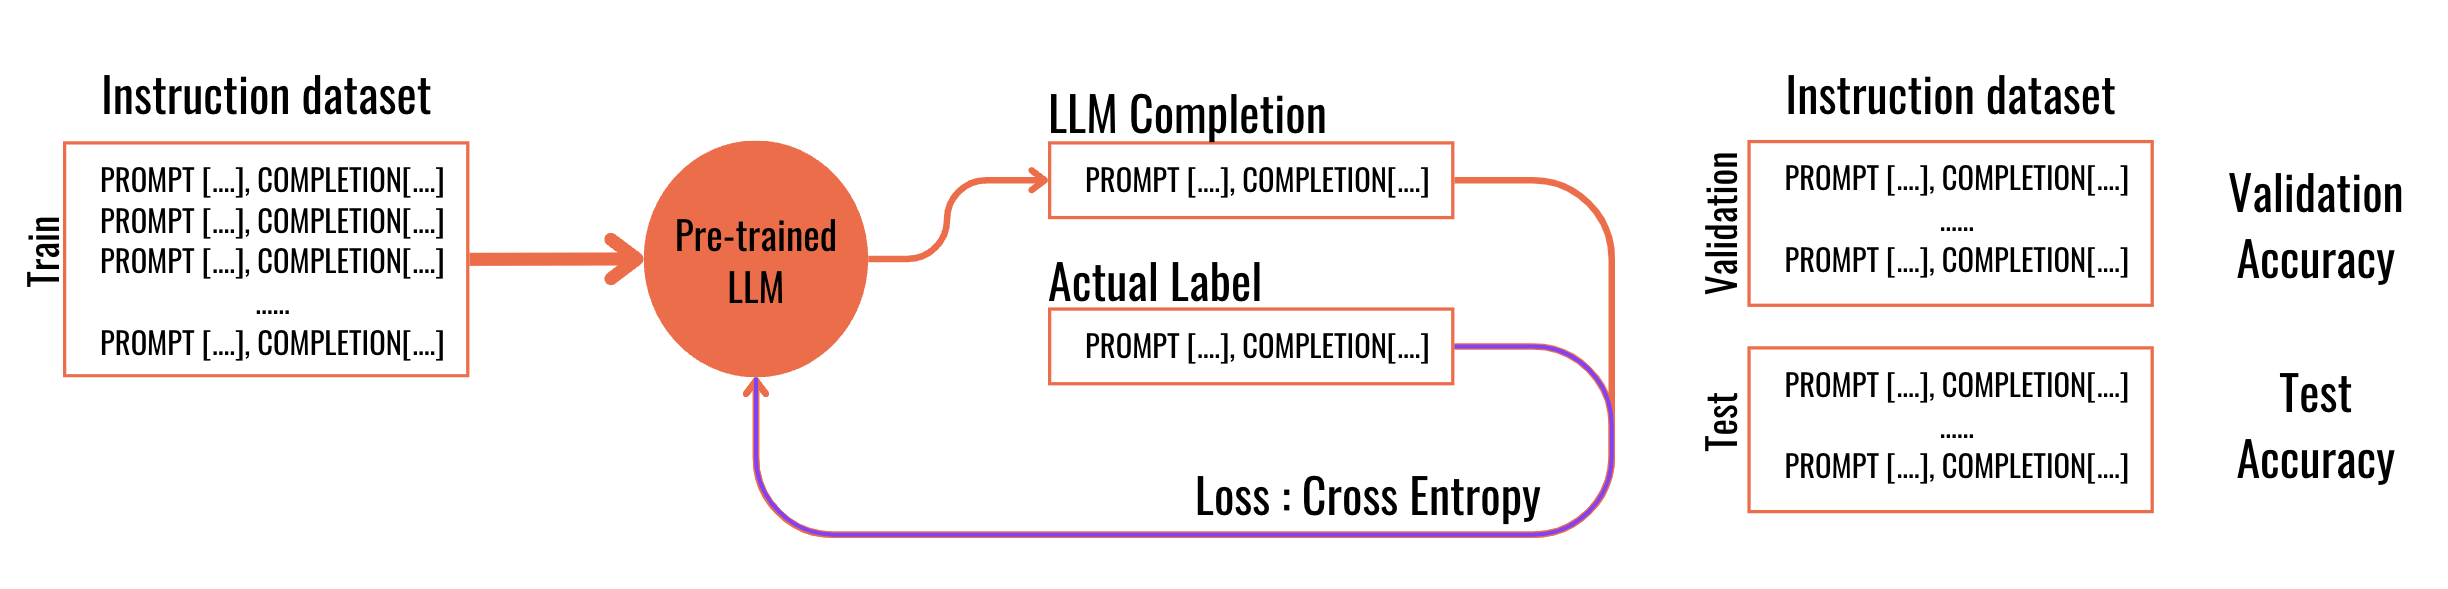

There are three broad steps in LLM finetuning -

1. Data Preparation (for the specific task/use case)
2. Training (chosen training methodology)
3. Evaluation

##### Fine-tuning OpenAI base models

- gpt-3.5-turbo-0613
- babbage-002
- davinci-002

###### Step 1 : Preparing the dataset

**Use Case** - Generate LLM responses in a defined language construct

https://drive.google.com/file/d/1n9iwa7dphWr43Ttbp0uXxhyGGtyFUO3M/view?usp=drive_link

- For babbage-002 and davinci-002 base models

In [ ]:
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}

- for gpt-3.5-turbo-0613 base model

In [ ]:
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [ ]:
data_folder_path='../Data/'
training_data_file='fine_tuning_data.csv'

In [ ]:
data_for_finetuning=pd.read_csv(data_folder_path+training_data_file)

In [ ]:
data_for_finetuning.head()

In [ ]:
data_for_finetuning.shape

In [ ]:
train_data, test_data = train_test_split(data_for_finetuning, test_size=0.2, random_state=42)

In [ ]:
train_data.shape

In [ ]:
test_data.shape

End of Sequence Token

In [ ]:
prompt_end="<--"
completion_end="-->"

In [ ]:
def convert_data_for_bd(data,file):
  with open(file,'w') as f:
    for _,rows in data.iterrows():
      prompt=rows['prompt']+prompt_end
      completion=rows['completion']+completion_end
      json_line = {"prompt": prompt, "completion": completion}
      f.write(json.dumps(json_line) + '\n')

  print(f'JSONlines file "{file}" has been created.')

In [ ]:
train_file_bd_name='train_bd.jsonl'
test_file_bd_name='test_bd.jsonl'


In [ ]:
convert_data_for_bd(train_data,data_folder_path+train_file_bd_name)
convert_data_for_bd(test_data,data_folder_path+test_file_bd_name)

In [ ]:
openai.File.create(
                file=open(data_folder_path+train_file_bd_name, "rb"),
                purpose='fine-tune'
)

In [ ]:
openai.File.create(
                file=open(data_folder_path+test_file_bd_name, "rb"),
                purpose='fine-tune'
)

###### Step 2 : Training

In [ ]:
openai.FineTuningJob.create(
              training_file="file-KiBdHEFjpLDPZygUmAbMt7jz",
              validation_file="file-d7SfXoBkdnLgTh4g3oHWf2Sa",
              model="davinci-002",
              suffix="AIML-Tutorial",
              hyperparameters={"n_epochs":1}
              )

In [ ]:
openai.FineTuningJob.list()

In [ ]:
openai.FineTuningJob.list_events(id="ftjob-ybFhNJz270olerQXcdXbUleb", limit=2)

###### Repeating step 1 & step 2 for 3.5 Turbo model

In [ ]:
def convert_data_for_turbo(data,file):
  with open(file,'w') as f:
    for _,rows in data.iterrows():
      prompt=rows['prompt']+prompt_end
      completion=rows['completion']+completion_end
      json_line = {'messages': [{'role': 'system',
                                'content': ''},
                                {'role': 'user',
                                 'content': prompt},
                                {'role': 'assistant',
                                'content': completion}]}
      f.write(json.dumps(json_line) + '\n')

  print(f'JSONlines file "{file}" has been created.')

In [ ]:
train_file_turbo_name='train_turbo.jsonl'
test_file_turbo_name='test_turbo.jsonl'

In [ ]:
convert_data_for_turbo(train_data,data_folder_path+train_file_turbo_name)
convert_data_for_turbo(test_data,data_folder_path+test_file_turbo_name)

In [ ]:
openai.File.create(
                file=open(data_folder_path+train_file_turbo_name, "rb"),
                purpose='fine-tune'
)

In [ ]:
openai.File.create(
                file=open(data_folder_path+test_file_turbo_name, "rb"),
                purpose='fine-tune'
)

In [ ]:
openai.FineTuningJob.create(
              training_file="file-ura1xq7Js10JeRdeYRa4ZIv2",
              validation_file="file-vdfOTY3RbI1WLvOsBSwoVEvB",
              model="gpt-3.5-turbo-0613",
              suffix="AIML-Tutorial",
              hyperparameters={"n_epochs":1}
              )

In [ ]:
openai.FineTuningJob.list(limit=2)

In [ ]:
openai.FineTuningJob.list_events(id="ftjob-mLdDXP9ls9eLCugPIBpkN86S", limit=2)

###### Step 3: Evaluation

Example 1

In [ ]:
test_data.iloc[0]["prompt"]

In [ ]:
prompt=str(test_data.iloc[0]["prompt"])+prompt_end

In [ ]:
response=openai.Completion.create(model="ft:davinci-002:yarnit-innovations-pvt-ltd:aiml-tutorial:8AZYai1j",
                                        prompt=prompt,
                                        temperature=0.9,
                                        max_tokens=100,
                                        top_p=1,
                                        frequency_penalty=1,
                                        presence_penalty=1,
                                        user="user_id")

In [ ]:
response.choices[0].text

In [ ]:
response.choices[0].text.split(completion_end)[0]

In [ ]:
test_data.iloc[0]["completion"]

**Example 2**

In [ ]:
topic="Explain server side events"

In [ ]:
prompt=topic+prompt_end

In [ ]:
response=openai.Completion.create(model="ft:davinci-002:yarnit-innovations-pvt-ltd:aiml-tutorial:8AZYai1j",
                                        prompt=prompt,
                                        temperature=0.9,
                                        max_tokens=100,
                                        top_p=.5,
                                        frequency_penalty=.5,
                                        presence_penalty=.5,
                                        user="user_id")

In [ ]:
response.choices[0].text.split(completion_end)[0]

In [ ]:
model="ft:gpt-3.5-turbo-0613:yarnit-innovations-pvt-ltd:aiml-tutorial:8AZkWQyf"

In [ ]:
response=openai.ChatCompletion.create(model=model,
                            messages=[{"role":"user","content":prompt}],
                            temperature=.7,
                            max_tokens=500,
                            top_p=1,
                            frequency_penalty=1,
                            presence_penalty=1,
                            user="tutuser001")

In [ ]:
response.choices[0].message.content.split(completion_end)[0]

##### Fully Fine-tuning an Open Source Model (EleutherAI - pythia-70m)

###### downloading Pythia 70M model from Hugging Face

In [ ]:
model_name = "EleutherAI/pythia-70m"

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

###### downloading the tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

###### tokenization illustration

In [ ]:
data_for_finetuning.iloc[0]["prompt"]

In [ ]:
tokenizer(data_for_finetuning.iloc[0]["prompt"])

In [ ]:
encoded_text=tokenizer(data_for_finetuning.iloc[0]["prompt"])["input_ids"]
print(encoded_text)

In [ ]:
decoded_text = tokenizer.decode(encoded_text)
print(decoded_text)

###### tokenizing and splitting the entire dataset

In [ ]:
def tokenize_function(examples):
    text = str(examples["prompt"][0])+"-->" + str(examples["completion"][0]) + "<--"

    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        padding=True,
    )

    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        2048
    )
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=max_length
    )

    return tokenized_inputs

In [ ]:
finetuning_dataset_loaded=Dataset.from_pandas(data_for_finetuning)

In [ ]:
tokenized_dataset = finetuning_dataset_loaded.map(
    tokenize_function,
    batched=True,
    batch_size=1,
    drop_last_batch=True
)

In [ ]:
print(tokenized_dataset)

In [ ]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

In [ ]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True, seed=145)
print(split_dataset)

In [ ]:
split_dataset["train"]

###### training

In [ ]:
device_count = torch.cuda.device_count()
if device_count > 0:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

In [ ]:
base_model.to(device)

In [ ]:
from transformers import TrainingArguments, Trainer


In [ ]:
OUTPUT_DIR='../Model'

In [ ]:
training_args = TrainingArguments(
    # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=3,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=384,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=OUTPUT_DIR,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=60, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)


In [ ]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],

)


In [ ]:
trainer.train()

In [ ]:
save_dir = OUTPUT_DIR+"/final_model"

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

In [ ]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)

In [ ]:
finetuned_slightly_model.to(device)

###### Generating text from the model

In [ ]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )




  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )



  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)




  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text)+3:].split("<--")[0]

  return generated_text_answer

In [ ]:
inference("share information about Benefits Of Mindfulness Meditation", finetuned_slightly_model, tokenizer)

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
inference("share information about Benefits Of Mindfulness Meditation", base_model, tokenizer)